In [1]:
import jax.numpy as jnp
from jax import random,jit,vmap

In [2]:
from obe_jax import SimulatedModel, AbstractBayesianModel

# Define Example Experiment

In [226]:
true_params = jnp.asarray([5,100]).reshape(2,1)
wmin,wmax = [4,6]
t2min,t2max = [75,150]

In [227]:
@jit
def likelihood(oneinput,oneoutput,oneparam):
    w = oneparam[0]
    t2 = oneparam[1]
    t = oneinput[0]
    out = oneoutput[0]
    p0 = jnp.exp(-t/t2)*jnp.square((jnp.cos(w*t/2)))+(1-jnp.exp(-t/t2))/2
    var = 0.001
    weight = jnp.exp(-((out-0)**2)/var)
    p_output = weight*p0+(1-weight)*(1-p0)
    return p_output

In [283]:
N = 100
key = random.PRNGKey(50)
ws = random.uniform(key,shape=(N,),minval=wmin,maxval=wmax)
key, subkey = random.split(key)
t2 = random.uniform(subkey,shape=(N,),minval=t2min,maxval=t2max)

In [284]:
prior_particles = jnp.vstack((ws,t2))
prior_weights = jnp.full(N,1/N)

In [285]:
@jit
def entropy_change(current_particles,current_weights,likelihoods):
    new_weights = current_weights*likelihoods
    new_weights = new_weights/jnp.sum(new_weights)
    H_old = jnp.sum(current_weights*jnp.log2(current_weights))
    H_new = jnp.sum(new_weights*jnp.log2(new_weights))
    return H_new-H_old

@jit
def relative_entropy(current_particles,current_weights,likelihoods):
    new_weights = current_weights*likelihoods
    new_weights = new_weights/jnp.sum(new_weights)
    log_rel = jnp.log2(jnp.divide(current_weights,new_weights))
    return -jnp.sum(new_weights*log_rel)

@jit
def posterior_variance(current_particles,current_weights,likelihoods):
    new_weights = current_weights*likelihoods
    new_weights = new_weights/jnp.sum(new_weights)
    raw_covariance = jnp.cov(current_particles, aweights=new_weights)
    return -jnp.trace(raw_covariance)

In [286]:
expected_outputs = jnp.asarray([0.0,1.0]).reshape(1,2)

In [308]:
key = random.PRNGKey(1)

pdf = AbstractBayesianModel(key,prior_particles, prior_weights, 
                            likelihood_function=likelihood, 
                            utility_measure=entropy_change, 
                            expected_outputs=expected_outputs)

In [309]:
pdf.mean()

Array([  5.0235486, 112.83939  ], dtype=float32)

In [310]:
ws = []
t2s = []

In [311]:
n_runs = 100
tmin = 0.001
tmax = 200
k=10
n_guesses_per_run = 1000

In [312]:
newkey = random.PRNGKey(2)
inputs = []
for i in range(n_runs):
    newkey, oldkey = random.split(newkey)
    ts = random.exponential(oldkey,(1,n_guesses_per_run))*100
    utils = pdf.expected_utilities_k_particles(ts,k)
    best_t = ts[:,jnp.argmax(utils)]
    inputs.append(best_t)
    out = pdf.sample_output(best_t,true_params)
    pdf.bayesian_update(best_t,out)
    old_t = best_t
    m = pdf.mean()
    ws.append(m[0])
    t2s.append(m[1])

In [313]:
pdf.mean()

Array([  5.0003996, 102.5936   ], dtype=float32)

In [314]:
import matplotlib.pyplot as plt
%matplotlib inline

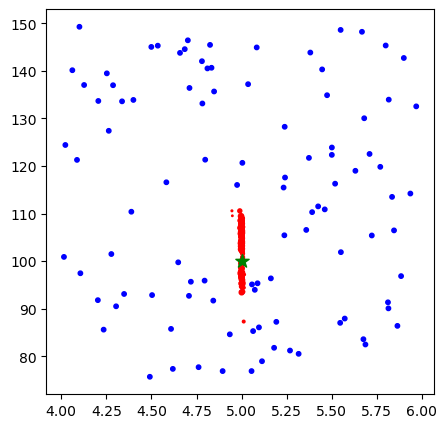

In [315]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(prior_particles[0,:],prior_particles[1,:],s=prior_weights*1000,c='b')
ax.scatter(pdf.particles[0,:],pdf.particles[1,:],s=pdf.weights*1000,c='r')
ax.scatter(true_params[0],true_params[1],s=100,marker='*',c='g')

plt.show()

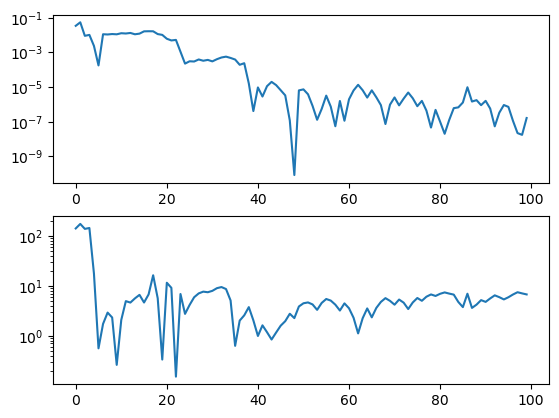

In [316]:
fig, (ax1,ax2) = plt.subplots(2,1)
ax1.plot((true_params[0]-jnp.asarray(ws))**2)
ax1.set_yscale('log')
ax2.plot((true_params[1]-jnp.asarray(t2s))**2)
ax2.set_yscale('log')
plt.show()